In [1]:
import pytorch_lightning as pl
from torch import nn
import torch
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)


class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=32, input_height=256):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        
        self.total_recons = []
        self.total_kl = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        self.total_recons.append(recon_loss.mean().item())
        self.total_kl.append(kl.mean().item())
        
        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

In [2]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor(),transforms.Resize(256)])

train_ok_path = 'dataset/archive/casting_data/casting_data/train_one_class'
trainset = torchvision.datasets.ImageFolder(train_ok_path, transform = transform)
trainloader = DataLoader(trainset, batch_size=16, shuffle = True, num_workers=5)


In [3]:
pl.seed_everything(1234)

vae = VAE()
trainer = pl.Trainer(gpus=1,max_epochs=200, progress_bar_refresh_rate=10)
trainer.fit(vae, trainloader)

Global seed set to 1234
/home/comsee/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 6.8 M 
2 | fc_mu   | Linear        | 16.4 K
3 | fc_var  | Linear        | 16.4 K
------------------------------------------
18.0 M    Trainable para

Training: 0it [00:00, ?it/s]

In [6]:
torch.cuda.empty_cache()

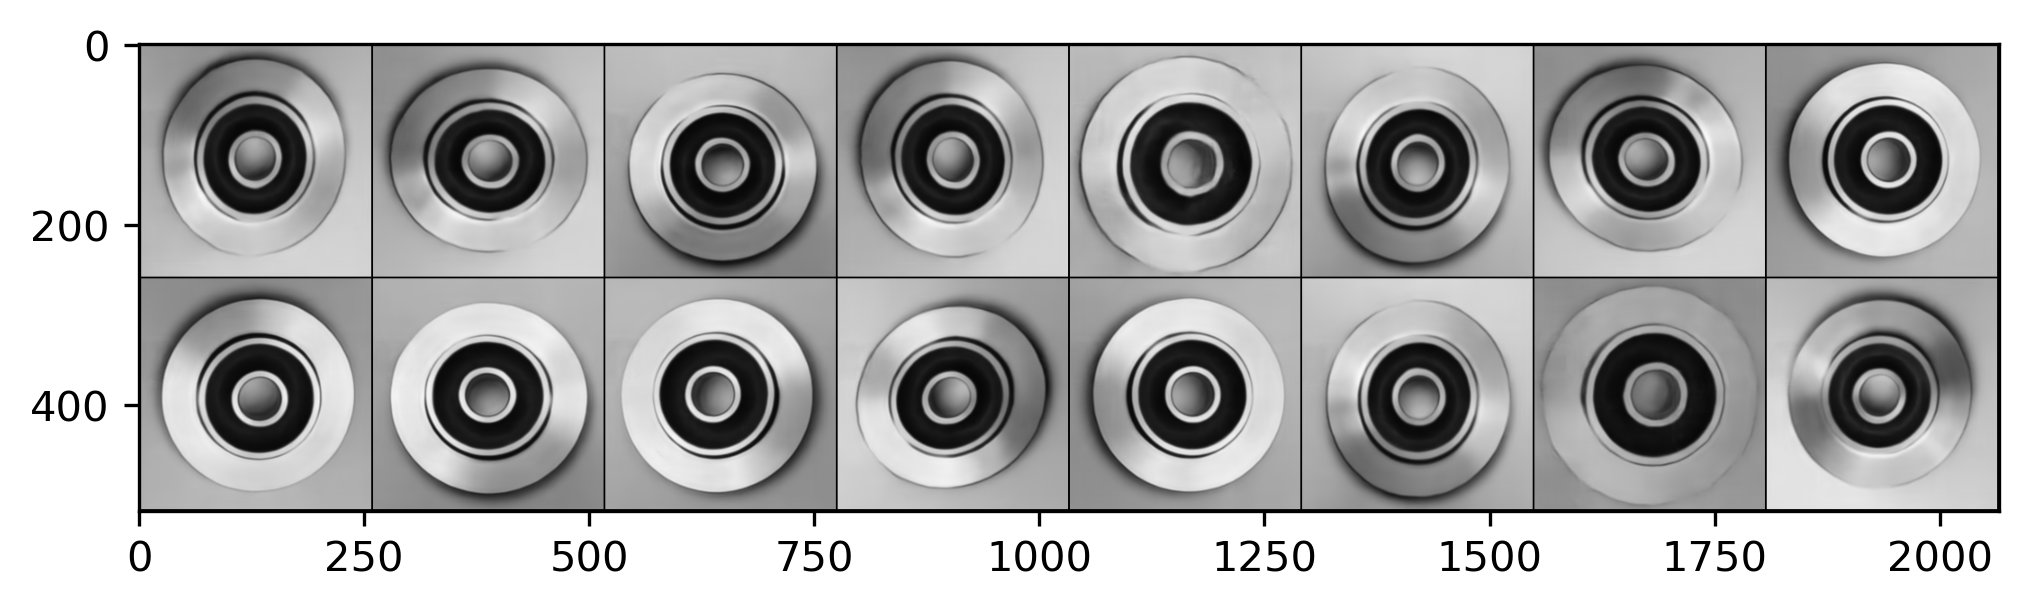

In [4]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
#from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

# Z COMES FROM NORMAL(0, 1)
num_preds = 16
exemple = iter(trainloader)
images, labels = next(exemple)
mu = vae.fc_mu(vae.encoder(images))
log_var = vae.fc_var(vae.encoder(images))
std = torch.exp(log_var/2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()

# SAMPLE IMAGES
with torch.no_grad():
    mu = vae.fc_mu(vae.encoder(images))
    log_var = vae.fc_var(vae.encoder(images))
    std = torch.exp(log_var/2)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()
    pred = vae.decoder(z.to(vae.device)).cpu()
    recon_loss = vae.gaussian_likelihood(pred, vae.log_scale, images)

    # kl
    kl = vae.kl_divergence(z, mu, std)

    # elbo
    elbo = (kl - recon_loss)
    #elbo = elbo.mean()

# UNDO DATA NORMALIZATION
#normalize = cifar10_normalization()
#mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).numpy() 
# PLOT IMAGES
imshow(img);

In [5]:
print(elbo)
print(kl)
print(recon_loss)

tensor([  178.3150,  -676.0361,  1191.5370,   262.1513,  -114.1604, -1192.5223,
         -663.6385,  -450.3251])
tensor([83.9110, 47.4711, 71.7790, 73.2680, 69.4490, 58.8845, 59.5770, 45.2233])
tensor([  -94.4040,   723.5072, -1119.7581,  -188.8833,   183.6094,  1251.4069,
          723.2155,   495.5484])


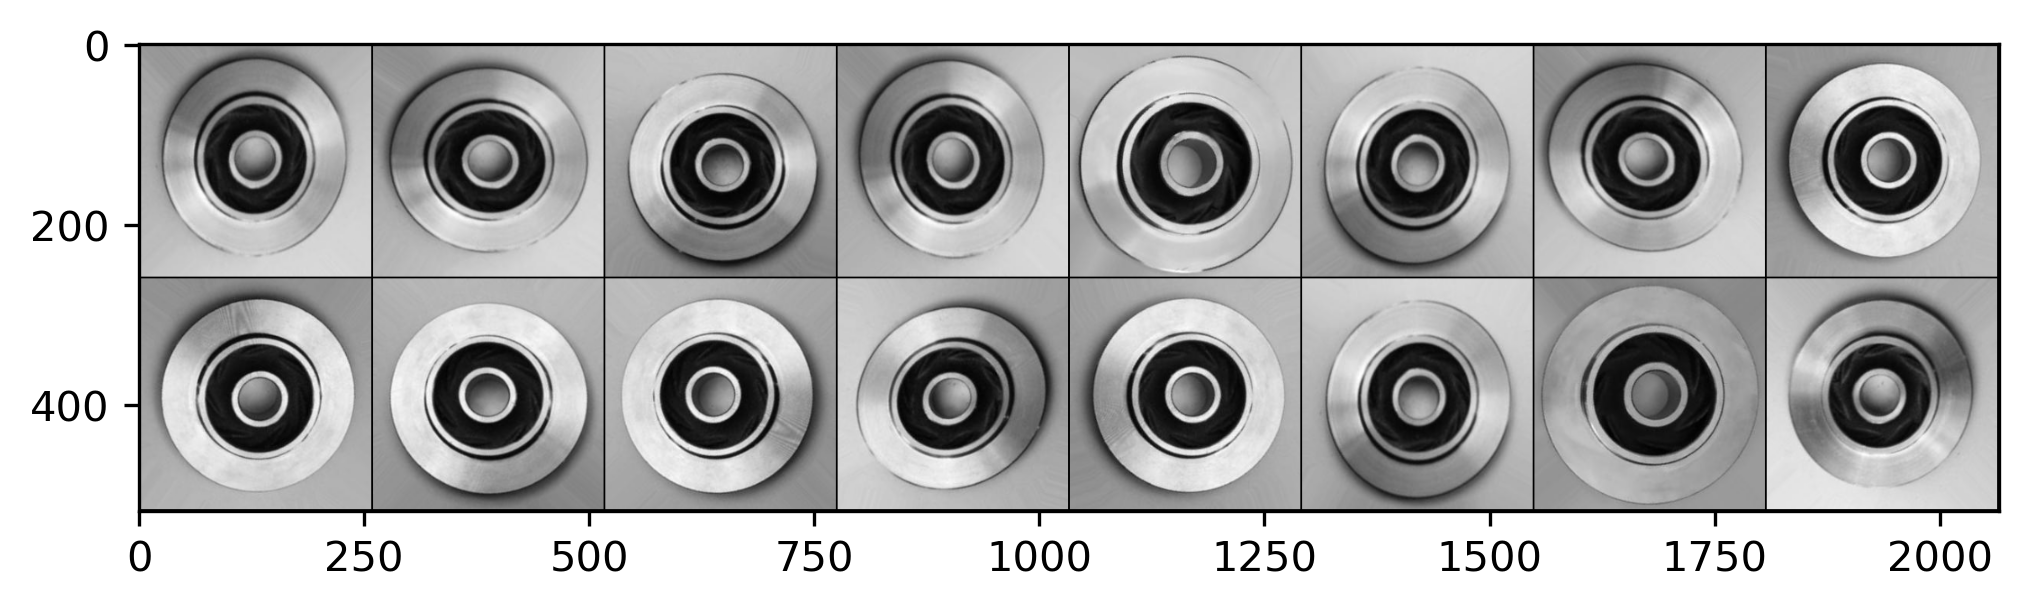

In [5]:
figure(figsize=(8, 3), dpi=300)
img_real = make_grid(images).permute(1,2,0).numpy()
imshow(img_real)

[7.130623817443848, 13.594893455505371, 17.27922821044922, 24.414173126220703, 29.222251892089844, 48.968746185302734, 47.45391082763672, 74.6802978515625, 87.28349304199219, 144.40415954589844, 143.17501831054688, 138.23951721191406, 124.08100891113281, 135.88287353515625, 168.24339294433594, 202.32431030273438, 173.7580108642578, 154.57870483398438, 138.40994262695312, 158.14865112304688]


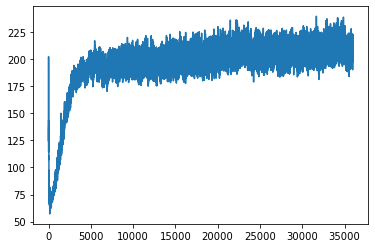

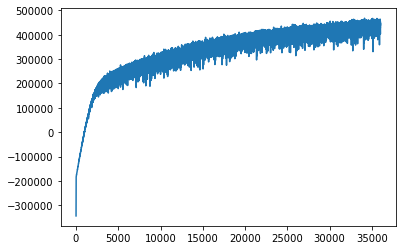

In [6]:
import matplotlib.pyplot as plt
print(vae.total_kl[0:20])
plt.figure(1)
plt.plot(vae.total_kl[10:])
plt.figure(2)
plt.plot(vae.total_recons)

0.0005593650275841355
(256, 256, 3)
0.0005679348832927644
(256, 256, 3)
0.00044699665158987045
(256, 256, 3)
0.0006299217930063605
(256, 256, 3)


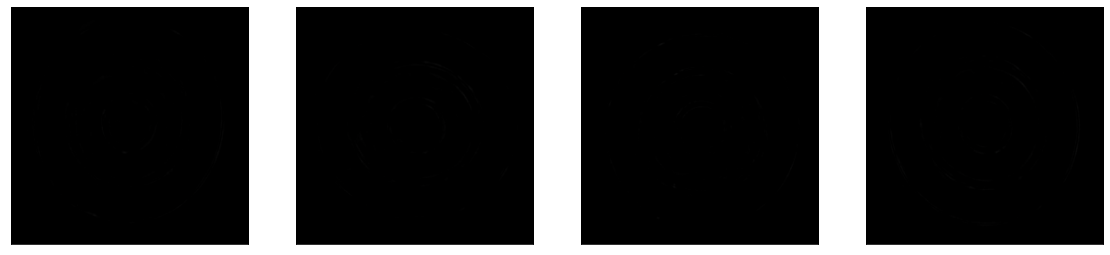

In [7]:
plt.figure(figsize=(40, 10))
for i in range(4):
    error = torch.pow(pred[i]-images[i],2)
    print(torch.mean(error).item())
    error = error.permute(1,2,0).detach().numpy()
    print(error.shape)
    ax = plt.subplot(1, 8, i + 1)
    plt.imshow(error,vmin=0,vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
train_def_path = 'dataset/archive/casting_data/casting_data/train_anomalous'
trainset_def = torchvision.datasets.ImageFolder(train_def_path, transform = transform)

trainloader_def = DataLoader(trainset_def, batch_size=4, shuffle = True)

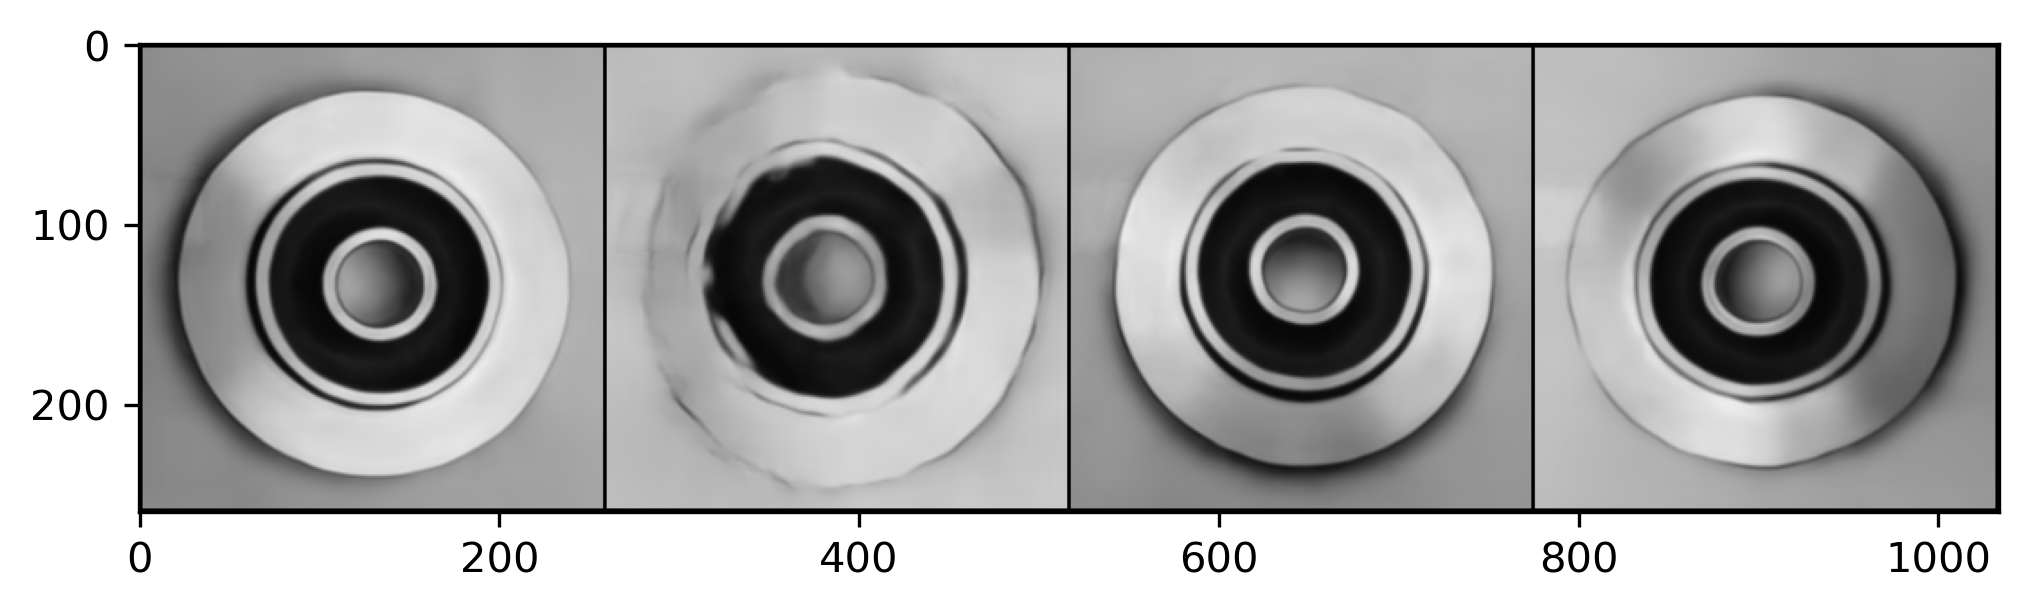

In [9]:
figure(figsize=(8, 3), dpi=300)
exemple = iter(trainloader_def)
images, labels = next(exemple)

# SAMPLE IMAGES
with torch.no_grad():
    mu = vae.fc_mu(vae.encoder(images))
    log_var = vae.fc_var(vae.encoder(images))
    std = torch.exp(log_var/2)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()
    pred = vae.decoder(z.to(vae.device)).cpu()
    recon_loss = vae.gaussian_likelihood(pred, vae.log_scale, images)

    # kl
    kl = vae.kl_divergence(z, mu, std)

    # elbo
    elbo = (kl - recon_loss)
    #elbo = elbo.mean()

# UNDO DATA NORMALIZATION
#normalize = cifar10_normalization()
#mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).numpy() 
# PLOT IMAGES
imshow(img);

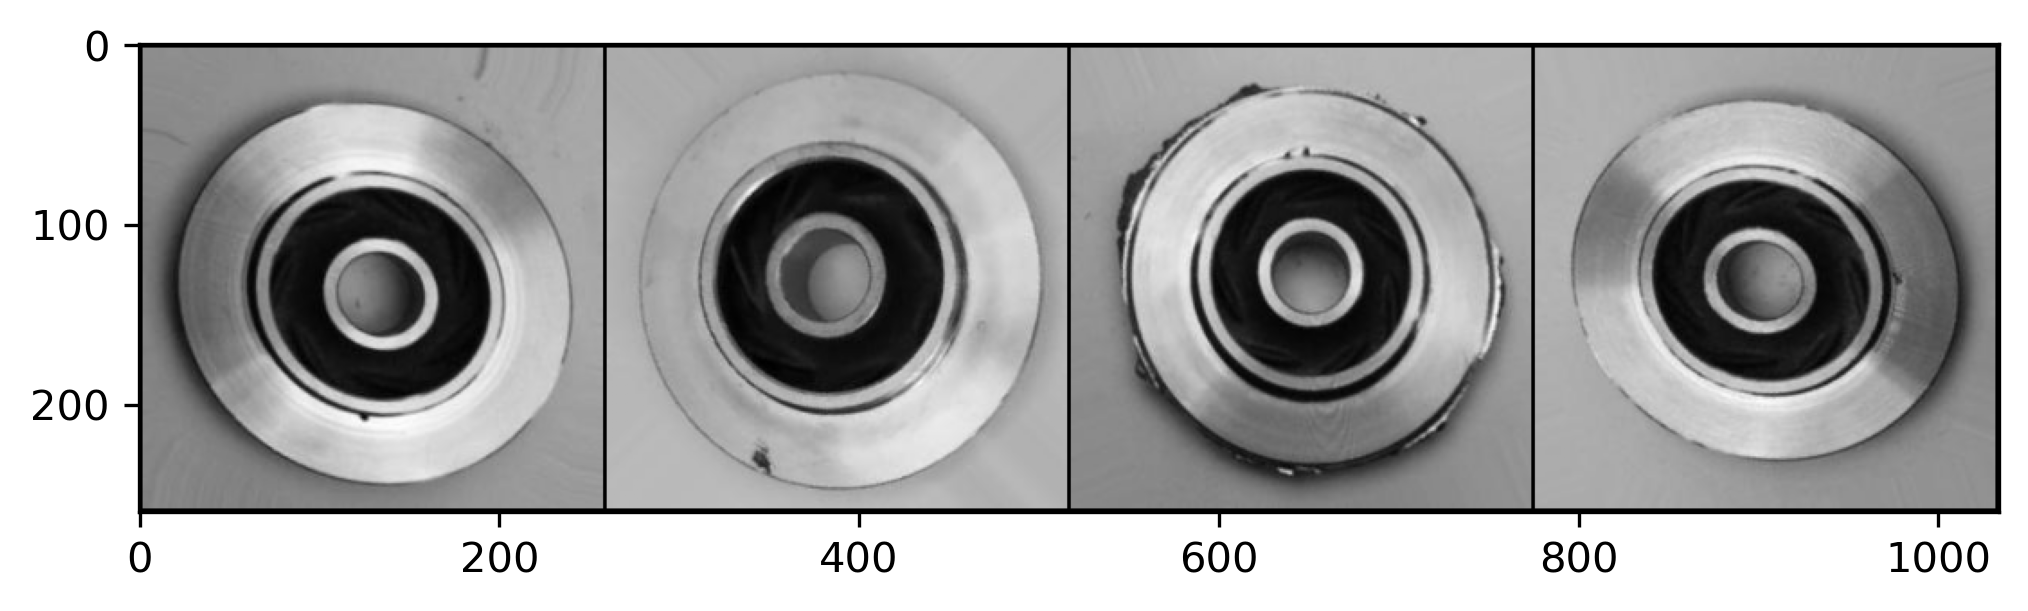

In [10]:
figure(figsize=(8, 3), dpi=300)
img_real = make_grid(images).permute(1,2,0).numpy()
imshow(img_real)

0.027851806953549385
(256, 256, 3)
0.010629795491695404
(256, 256, 3)
0.027012595906853676
(256, 256, 3)
0.011929184198379517
(256, 256, 3)


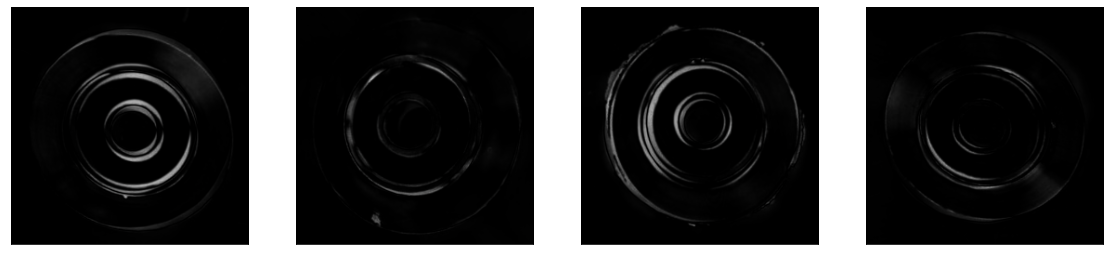

In [11]:
plt.figure(figsize=(40, 10))
for i in range(4):
    error = torch.pow(pred[i]-images[i],2)
    print(torch.mean(error).item())
    error = error.permute(1,2,0).detach().numpy()
    print(error.shape)
    ax = plt.subplot(1, 8, i + 1)
    plt.imshow(error,vmin=0,vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
test_path = 'dataset/archive/casting_data/casting_data/test'
alltestset = torchvision.datasets.ImageFolder(test_path, transform = transform)
alltestloader = DataLoader(alltestset, batch_size=1, shuffle = False)

loss_function = nn.MSELoss()
losses = []
labels = []
predictions = []
classes = ['def','ok']
count_ok = 0
with torch.no_grad():
    for images, label in alltestset:
        images = images.reshape(1,3,256,256)
        encoded = vae.encoder(images)
        mu = vae.fc_mu(encoded)
        log_var = vae.fc_var(encoded)
        std = torch.exp(log_var/2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        pred = vae.decoder(z.to(vae.device)).cpu()
        loss = loss_function(pred,images)
        losses.append(loss.item())
        labels.append(classes[label])
        
        pred = pred.reshape(1,3,256,256)
        error_image = torch.pow(pred-images,2)
        recons_error = torch.mean(error_image)
        if recons_error > 0.016:
            predictions.append(classes[0])
        else:
            predictions.append(classes[1])

print(len(predictions))
print(len(labels))

715
715


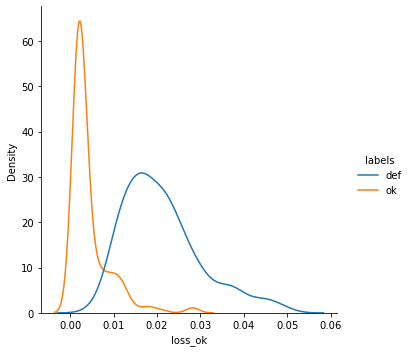

In [13]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(losses, columns=['loss_ok'])
df['labels'] = labels
#df_def = pd.DataFrame(losses_def, columns=['loss_def'])
sns.displot(df,x="loss_ok" ,hue="labels", kind="kde")

[Text(0, 0.5, 'def'), Text(0, 1.5, 'ok')]

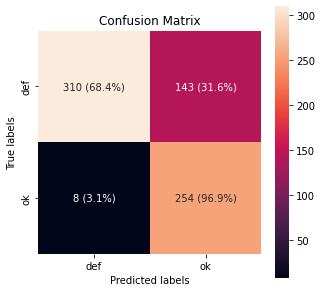

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

matrix = confusion_matrix(labels, predictions, labels=classes)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
# Create labels with percentage
annot = [["00","01"],["10","11"]]
for i in range(2):
    for j in range(2):
        percentage = matrix[i][j] / sum(matrix[i]) * 100
        annot[i][j] = f"{matrix[i][j]} ({percentage:.1f}%)"

# Plot the confusion matrix with Seaborn
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(matrix, annot=annot, square=True, fmt="s", ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels([classes[0], classes[1]])
ax.yaxis.set_ticklabels([classes[0], classes[1]])

In [16]:
trainer.save_checkpoint("VAe_200_epochs.ckpt")